# HW4A: The Local Model

### Bhaven Patel
### 4/17/2019

I worked with Anthony Rentsch, Lipika Ramaswamy, and Karina Huang on this homework.

My code can be found on my [Github](https://github.com/bhavenp/cs208/blob/master/homework/HW4/HW4_Bhaven_Patel.ipynb).

## Problem 1: Learning Conjunctions in the SQ Model

### (a)

### Centralized Version of SQ Model


For the centralized version of the SQ model, I chose to calculate $p_j = P[x[j]=0 \,\wedge\, y=1]$ for $j=1,...,d$. 
To do this, I create a "conjunction matrix" where the element at the $i$-th row ($i=1,...,n$) and the $j$-th column ($j=1,...,d$) contains an indicator as to whether $x_{ij}=0 \wedge y_i=1$ in the original dataset. $p_j$ is just the mean of the $j$-th column in the conjunction matrix.

Then, laplace noise is added to $p_j$ with a scale equal to $\dfrac{GS}{\tilde\epsilon}$, where the global sensitivity $GS=\dfrac{1}{n}$ and $\tilde\epsilon= \dfrac{\epsilon}{d}$. The $GS=\dfrac{1}{n}$ because changing one value ($0\rightarrow 1$ or $1\rightarrow 0$) in the column $j$ changes $p_j$ by $\dfrac{1}{n}$. Thus, every $p_j$ has a differentially private release $\hat p_j$
$$
\hat p_j = p_j + Lap\left(\dfrac{d}{n\tilde\epsilon}  \right)
$$

Each $\hat p_j$ is compared to a threshold $t$ to determine if the feature $j$ should be included in the set $\hat S$ that is returned.

Below are the helper functions we generally use.

In [1]:
rm(list=ls())		# Remove any objects in memory

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))

sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

In [2]:
##function to create the matrix that holds an indicator if x_j==0 & y==1
createConjunctionMat <- function(xData, yData){
    #create matrix to hold indicator if x_j==0 & y==1
    result_matrix = matrix(0, nrow=nrow(xData), ncol=ncol(xData));
    for(i in 1:nrow(xData)){
        if(yData[i] == 1){ #only need to consider row if y=1
            result_matrix[i, ] <- (xData[i, ] == 0); #check if x_j == 0
        }
    }
    return(result_matrix);
}

#function to calculate DP-releases for each probability
probRelease <- function(xMat, epsilon=1.0){
    probs <- colMeans(xMat); #calculate true probabilities
    sensitivity <- 1 / nrow(xMat); #sensitivity is 1/n
    scale <- sensitivity / epsilon;
    dpProbs <- probs + rlap(mu=0, b=scale, size=length(probs)); #add laplace noise to the true probabilities

	return(list(release=dpProbs, true=probs) );
}

#function that ties together the different parts for doing a DP release of the probabilities for a 
## xData: matrix of {0,1}
## yData: vector of {0,1}, same length as number of rows in xData
## epsilon: total privacy-loss parameter. This will get split up by the number of columns in xData that 
##          we must release probabilities for
## returns a list containing a vector of the indices corresponding to the columns of xData that predict yData well,
## a vector of the DP released probabilities calculated for each column, and a vector of the true probabilities

centrlDP_SQAlg <- function(xData, yData, totEpsilon=1.0, threshold=1e-4){
    pMatrix <- createConjunctionMat(xData=xData, yData=yData); #create conjunction matrix

    dpRelease <- probRelease(pMatrix, epsilon = totEpsilon/ncol(xData) ); #get DP release of probabilities
    indices <- which(dpRelease$release < threshold); #get indices with probability less than threshold
    return(list(indices=indices, dpProbs=dpRelease$release, trueProbs=dpRelease$true) );
}

Below I show that my centralized version of the SQ algorithm works for the *hw4testdata.csv* file.

In [3]:
#read in the test data
mydata <- read.csv('../../data/hw4testdata.csv');
# mydata[0:10, ]

#get set of features to use as predictors
set.seed(42);
centrlDP_SQAlg(xData = mydata[, 1:10], yData = mydata[['y']], totEpsilon = 1.0, threshold = .01)

$indices
[1] 1 2 3

$dpProbs
 [1]  1.769678e-04  2.072671e-04 -5.581285e-05  6.207814e-02  6.055334e-02
 [6]  6.118389e-02  6.161409e-02  6.166882e-02  6.089769e-02  6.109279e-02

$trueProbs
 [1] 0.00000 0.00000 0.00000 0.06197 0.06052 0.06118 0.06155 0.06180 0.06086
[10] 0.06104

### Local Model

For the local model implementation of the SQ algorithm, I begin by creating a "conjunction matrix" where the element in the $i$-th row ($i=1,...,n$) and the $j$-th column ($j=1,...,d$) contains an indicator $\hat x_{ij}$ as to whether $x_{ij}=0 \wedge y_i=1$ in the original dataset. This is the same step I took for the centralized DP version of the SQ algorithm.  <br>

Then, I perform a randomized response on each row of the conjunction matrix. My $\epsilon$ is split into $\tilde\epsilon= \dfrac{\epsilon}{d}$, and each indicator variable $\hat x_{ij}$ in the row is returned as follows 
$$
Q(\hat x_{ij}) = 
\begin{cases}
\hat x_{ij}, &w.p. \:\: \dfrac{e^{\tilde\epsilon} }{1 + e^{\tilde\epsilon}} \\
\\
1 - \hat x_{ij}, &w.p. \:\: \dfrac{1}{1 + e^{\tilde\epsilon} }\\
\end{cases}
$$

Using the randomized responses on the "conjunction matrix", I can calculate $\hat p_j$ by taking the mean of each column $j$ in the randomized-response matrix. However, we need to calculate the correction factor to apply to the $\hat p_j$s because want $E[\hat p_j]=p_j$. We can begin with:
$$\begin{align}
E[\hat p_j] &= p_j\\
\\
E \left[\dfrac{1}{n} \sum_{i=1}^n Q(\hat x_{ij}) \right] &= \dfrac{1}{n} \sum_{i=1}^n \hat x_{ij}\\
\\
\dfrac{1}{n} \sum_{i=1}^n  E \left[ Q(\hat x_{ij}) \right] &= \dfrac{1}{n} \sum_{i=1}^n \hat x_{ij}\\
\\
\sum_{i=1}^n  E \left[ Q(\hat x_{ij}) \right] &= \sum_{i=1}^n \hat x_{ij}\\
\end{align}$$

From the definition of $Q(\hat x_{ij})$ above, we can calculate $E \left[ Q(\hat x_{ij}) \right]$:
$$\begin{align}
E \left[ Q(\hat x_{ij}) \right] &= \hat x_{ij}\dfrac{e^\tilde\epsilon}{1 + e^\tilde\epsilon } + (1 - \hat x_{ij})\dfrac{ 1}{1 + e^\tilde\epsilon }\\
&= \hat x_{ij} \dfrac{e^\tilde\epsilon - 1}{1 + e^\tilde\epsilon } + \dfrac{1}{1 + e^\tilde\epsilon }
\end{align}$$

We can substitute this result in to get
$$\begin{align}
\sum_{i=1}^n  E \left[ Q(\hat x_{ij}) \right] &= \sum_{i=1}^n \hat x_{ij}\\
\\
\sum_{i=1}^n \left( \hat x_{ij} \dfrac{e^\tilde\epsilon - 1}{1 + e^\tilde\epsilon } + \dfrac{1}{1 + e^\tilde\epsilon } \right) &= \sum_{i=1}^n \hat x_{ij}\\
\\
\dfrac{n}{1 + e^\tilde\epsilon } + \dfrac{e^\tilde\epsilon - 1}{1 + e^\tilde\epsilon } \sum_{i=1}^n \hat x_{ij} &= \sum_{i=1}^n \hat x_{ij}\\
\end{align}$$

From this result, we see that we need to multiply the left side by some factor $c$ and add a quantity $d$ so that it is equivalent to the right side.
$$
d + c\cdot(\dfrac{n}{1 + e^\tilde\epsilon } + \dfrac{e^\tilde\epsilon - 1}{1 + e^\tilde\epsilon } \sum_{i=1}^n \hat x_{ij}) = \sum_{i=1}^n \hat x_{ij}\\
$$
If $c=\dfrac{1 + e^\tilde\epsilon }{e^\tilde\epsilon - 1}$ and $d=\dfrac{-n}{e^\tilde\epsilon -1}$, then the two sides of the equation are equivalent. Thus, we find that we must correct the sum $\sum_{i=1}^n \hat x_{ij}$ of each column $j$ by multiplying the sum by $\dfrac{1 + e^\tilde\epsilon }{e^\tilde\epsilon - 1}$ and adding a factor $\dfrac{-n}{e^\tilde\epsilon -1}$. We can then divide each of these corrected sums by $n$ to get our $\hat p_j$s.

Each $\hat p_j$ is compared to a threshold $t$ to determine if the feature $j$ should be included in the set $\hat S$ that is returned.

In [3]:
#local release mechanism works for x as a vector. Adjusted from J. Honaker's localRelease.ipynb.
##
## x: vector of {0,1} for which local release must be performed
## values: vector of length two containing the possible values in vector 'x'
## epsilon: privacy-loss parameter to use for flipping values in 'x'
## returns a vector

localReleaseVec <- function(x, values=c(0,1), epsilon){
	draws <- runif(n=length(x), min=0, max=1); #get number of draws equal to length of the vector
	cutoff <- 1/(1+exp(epsilon));
    release <- x; #make a copy of the vector x
    for(i in 1:length(x)){
        if(draws[i] < cutoff){ #we are going to flip the our value
            release[i] <- values[ !values %in% x[i] ] ; #create flag with (!values %in% x) for opposite value of 'x'
        }
    } 
    return(release);
}


#function that ties together the different parts for doing a DP release of the probabilities for a local model
## xData: matrix of {0,1}
## yData: vector of {0,1}, same length as number of rows in xData
## epsilon: total privacy-loss parameter. This will get split up by the number of columns in xData that 
##          we must release probabilities for
## returns a list containing a vector of the indices corresponding to the columns of xData that predict yData well
## and a vector of the DP released probabilities calculated for each column, and a vector of the true probabilities

localDP_SQAlg <- function(xData, yData, totEpsilon=1.0, threshold=1e-4){
    cjMatrix <- createConjunctionMat(xData=xData, yData=yData);#create conjunction matrix
    trueProbs <- colMeans(cjMatrix); #calculate the true probabilities for each column/feature
    epsSplit <- totEpsilon / ncol(xData); #divide the total epsilon by the number of features

    #perform local release of conjunction matrix 
    lrMatrix <- cjMatrix; #create a copy of the conjunction matrix
    for(r in 1:nrow(cjMatrix)){
        lrMatrix[r, ] <- localReleaseVec(x=cjMatrix[r, ], values = c(0,1), epsilon = epsSplit);
    }
    
    dpSums <- colSums(lrMatrix); #get sums of the local release of the conjunction matrix
    #perform correction
    inflation <- (exp(epsSplit) + 1) / (exp(epsSplit) - 1); #coefficient to multiply each sum by
    n <- nrow(xData); #get number of rows
    additive <- -n / (exp(epsSplit) - 1); #additive factor to apply for because data is {0,1}

    dpProbs <- (dpSums * inflation + additive) / n;

    indices <- which(dpProbs < threshold); #get indices with probability less than threshold
    return(list(indices=indices, dpProbs=dpProbs, trueProbs=trueProbs));
}

Below I show that my local version of the SQ algorithm works for the *hw4testdata.csv* file.

In [5]:
set.seed(42);
mydata <- read.csv('../../data/hw4testdata.csv');
localDP_SQAlg(xData = mydata[, 1:10], yData = mydata[['y']], totEpsilon = 1.0, threshold = 0.01)

$indices
[1] 1 2 3

$dpProbs
 [1] -0.01022476 -0.05606292 -0.01142576  0.04201873  0.04942490  0.04522140
 [7]  0.06003373  0.08225222  0.06483773  0.03721473

$trueProbs
 [1] 0.00000 0.00000 0.00000 0.06197 0.06052 0.06118 0.06155 0.06180 0.06086
[10] 0.06104

### (b)

### Centralized DP version of SQ algorithm

I will refer to the $d$ columns in each dataset $x_i$ as features.<br>
$P[\hat S \not\supseteq S]$ is the probability that set $S$ contains a feature $j$ that $\hat S$ does not. This equivalent to determining the probability that at least one of the features $j \in S$ has DP-released $\hat p_j$ that is greater than the threshold $t$ we specify. Thus, we get
$$
P[\hat S \not\supseteq S] = \sum_{j\in S} P[\hat p_j > t]
$$

For the centralized DP SQ algorithm, I chose $\hat p_j = p_j + Lap\left(\dfrac{d}{n\tilde\epsilon}\right)$. Additionally, we know that for each $j \in S$, we have $p_j =0$. Thus, we get
$$\begin{align}
P[\hat S \not\supseteq S] &= \sum_{j\in S} P[p_j + Lap\left(\dfrac{d}{n\tilde\epsilon}\right) > t]\\
&= \sum_{j\in S} P[0 + Lap\left(\dfrac{d}{n\tilde\epsilon}\right) > t]
\end{align}$$

This can be equation can be expanded to be in terms of $t$, $n$, $\epsilon$, and $|S|$ because we can expand the probability that a value chosen from the Laplace distribution is greater than $t$ and $\sum_{j\in S}=|S|$:
$$\begin{align}
&= \sum_{j\in S} P[0 + Lap\left(\dfrac{d}{n\tilde\epsilon}\right) > t] \\
&= |S| \cdot \int_t^{\infty} \dfrac{e^{(-|y|\cdot n\epsilon / d)}\cdot n\epsilon}{2d} dy\\
\end{align}$$

Now, if we say that $P[\hat S \not\supseteq S] \leq 0.1$, we can find an upper bound on what the threshold $t$ should be:
$$\begin{align}
P[\hat S \not\supseteq S] &\leq 0.1\\
\\
|S| \cdot \int_t^{\infty} \dfrac{e^{(-|y|\cdot n\epsilon / d)}\cdot n\epsilon}{2d} dy &\leq 0.1\\
\\
|S|\dfrac{n\epsilon}{2d} \cdot \int_t^{\infty} e^{(-|y|\cdot n\epsilon / d)} dy &\leq 0.1\\
\\
\\
\int_t^{\infty} e^{(-|y|\cdot n\epsilon / d)} dy &\leq \dfrac{(0.1)\cdot 2d}{|S|n\epsilon}\\
\\
\left[\dfrac{-d}{n\epsilon} e^{(-y\cdot n\epsilon / d)} \right]_t^{\infty} &\leq \dfrac{(0.1)\cdot 2d}{|S|n\epsilon}\\
\\
\dfrac{-d}{n\epsilon} \left[ e^{(-\infty \cdot n\epsilon / d)} - e^{(-t \cdot n\epsilon / d)} \right] &\leq \dfrac{(0.1)\cdot 2d}{|S|n\epsilon}\\
\\
-1 \left[ 0 - e^{(-t \cdot n\epsilon / d)} \right] &\leq \dfrac{(0.2)}{|S|}\\
\\
e^{(-t \cdot n\epsilon / d)} &\leq \dfrac{(0.2)}{|S|}\\
\\
-t  &\geq \dfrac{d}{n\epsilon} \log\left(\dfrac{(0.2)}{|S|} \right)\\
\\
t  &\leq \dfrac{-d}{n\epsilon} \log\left(\dfrac{(0.2)}{|S|} \right)\\
\end{align}$$

Thus, for the centralized DP SQ algorithm, we find that $t  \leq \dfrac{-d}{n\epsilon} \log\left(\dfrac{(0.2)}{|S|} \right)$ if we want $P[\hat S \not\supseteq S] \leq 0.1$.

### Local DP version of SQ algorithm

I will refer to the $d$ columns in each dataset $x_i$ as features.<br>
$P[\hat S \not\supseteq S]$ is the probability that set $S$ contains a feature $j$ that $\hat S$ does not. This equivalent to determining the probability that at least one of the features $j \in S$ has DP-released $\hat p_j$ that is greater than the threshold $t$ we specify. Thus, we get
$$
P[\hat S \not\supseteq S] = \sum_{j\in S} P[\hat p_j > t]
$$

In the local DP version of the SQ algorithm, $\hat p_j$ is calculated from the randomized-response "conjunction matrix". Thus, $\hat p_j = \dfrac{1}{n} \sum_{i=1}^n \hat x_{ij}$, where $\hat x_{ij}$ is the value in the $i$-th row and $j$-th column of the in the randomized-response "conjunction matrix". So we can expand $P[\hat p_j > t]$ as follows
$$\begin{align}
\sum_{j\in S} P[\hat p_j > t] &= \sum_{j\in S} P \left[ \dfrac{1}{n} \sum_{i=1}^n \hat x_{ij} > t \right]\\
\\
&= \sum_{j\in S} P \left[ \sum_{i=1}^n \hat x_{ij} > nt \right]\\
\end{align}$$

Because $j \in S$, in the original "conjunction matrix" the entire column $j$ would be zeroes. However after randomized-response, the zero values in column $j$ may have been flipped to 1s, so
$$
P[\hat x_{ij} = 1] \sim \text{Bernoulli}\left( \dfrac{1}{1+e^{\epsilon}} \right)\\
\sum_{i=1}^n \hat x_{ij} \sim \text{Bin}\left(n, \dfrac{1}{1+e^{\epsilon}} \right)
$$

We can approximate the Binomial distribution using a normal distribution with the mean and the variance of the Binomial distribution:
$$
\sum_{i=1}^n \hat x_{ij} \sim N( n\left(\dfrac{1}{1+e^\epsilon}\right), n\left(\dfrac{1}{1+e^\epsilon}\right)\left(\dfrac{e^\epsilon}{1+e^\epsilon}\right) )
$$

We can now standardize $P \left[ \sum_{i=1}^n \hat x_{ij} > nt \right]$ using the normal distribution:
$$
P \left[ \dfrac{\sum_{i=1}^n \hat x_{ij}-\frac{n}{1+e^\epsilon}}{\sqrt{\frac{ne^\epsilon}{(1+e^\epsilon)^2}} } 
> \dfrac{nt-\frac{n}{1+e^\epsilon}}{\sqrt{\frac{ne^\epsilon}{(1+e^\epsilon)^2}}} \right]
= P \left[ Z 
> \dfrac{nt-\frac{n}{1+e^\epsilon}}{\sqrt{\frac{ne^\epsilon}{(1+e^\epsilon)^2}}} \right]
$$

So we now have
$$\begin{align}
\sum_{j\in S} P \left[ \sum_{i=1}^n \hat x_{ij} > nt \right] &= \sum_{j\in S} P \left[ Z 
> \dfrac{nt-\frac{n}{1+e^\epsilon}}{\sqrt{\frac{ne^\epsilon}{(1+e^\epsilon)^2}}} \right]\\
&= |S| \cdot \Phi \left( \dfrac{nt-\frac{n}{1+e^\epsilon}}{\sqrt{\frac{ne^\epsilon}{(1+e^\epsilon)^2}}} \right)
\end{align}$$

Thus for the local DP version of the SQ algorithm $P[\hat S \not\supseteq S] = |S| \cdot \Phi \left( \dfrac{nt-\frac{n}{1+e^\epsilon}}{\sqrt{\frac{ne^\epsilon}{(1+e^\epsilon)^2}}} \right)$.

Now, if we say that $P[\hat S \not\supseteq S] \leq 0.1$, we can find an upper bound on what the threshold $t$ should be:
$$\begin{align}
P[\hat S \not\supseteq S] &\leq 0.1\\
\\
|S| \cdot \Phi \left( \dfrac{nt-\frac{n}{1+e^\epsilon}}{\sqrt{\frac{ne^\epsilon}{(1+e^\epsilon)^2}}} \right) &\leq 0.1\\
\\
|S| \cdot \Phi \left( \dfrac{\sqrt{n}t(1+e^\epsilon)-\sqrt{n}}{\sqrt{e^\epsilon}} \right) &\leq 0.1\\
\end{align}$$
$|S| \leq d$ so we get
$$\begin{align}
d \cdot \Phi \left( \dfrac{\sqrt{n}t(1+e^\epsilon)-\sqrt{n}}{\sqrt{e^\epsilon}} \right) &\leq 0.1\\
\\
\Phi \left( \dfrac{\sqrt{n}t(1+e^\epsilon)-\sqrt{n}}{\sqrt{e^\epsilon}} \right) &\leq \dfrac{0.1}{d}\\
\dfrac{\sqrt{n}t(1+e^\epsilon)-\sqrt{n}}{\sqrt{e^\epsilon}} &\leq \Phi^{-1}\left(\dfrac{0.1}{d}\right) \\
\sqrt{n}t(1+e^\epsilon) &\leq \sqrt{e^\epsilon}\Phi^{-1}\left(\dfrac{0.1}{d}\right) + \sqrt{n} \\
t &\leq \dfrac{\sqrt{e^\epsilon}\Phi^{-1}\left(\dfrac{0.1}{d}\right) + \sqrt{n}} {\sqrt{n}(1+e^\epsilon)} \\
\end{align}$$

Thus, for the local DP version of the SQ algorithm, we find that $t  \leq \dfrac{\sqrt{e^\epsilon}\Phi^{-1}\left(\dfrac{0.1}{d}\right) + \sqrt{n}} {\sqrt{n}(1+e^\epsilon)}$ if we want $P[\hat S \not\supseteq S] \leq 0.1$.

### (c)

### Centralized DP version SQ algorithm

From part (b), we know that the upper bound on the threshold $t$ is $t \leq \dfrac{-d}{n\epsilon} \log\left(\dfrac{(0.2)}{|S|} \right)$. For the *CaPUMS5full.csv* data, we can calculate the upper bound using $n=1223992$, $d=10$, $\epsilon = 1.0$, and $|S|=d=10$.
$$\begin{align}
t &= \dfrac{-d}{n\epsilon} \log\left(\dfrac{(0.2)}{|S|} \right)\\
&= \dfrac{10}{(1223992)(1.0)} \log\left(\dfrac{(0.2)}{10} \right)\\
&= 3.20 \cdot 10^{-5}
\end{align}$$

Thus for the *CaPUMS5full.csv* dataset, the upper bound on the threshold $t$ is $3.20 \cdot 10^{-5}$. I will use this threshold to show that my centralized DP SQ algorithm works on the *CaPUMS5full.csv* dataset.

In [4]:
#read in the test data
caPUMS <- read.csv('../../data/CaPUMS5full.csv');
print(paste(nrow(caPUMS), " rows in CA PUMS"));
caPUMS[1:3, ]

[1] "1223992  rows in CA PUMS"


sex,married,black,asian,collegedegree,employed,militaryservice,uscitizen,disability,englishability,blackfemale,targetted
1,1,0,0,0,1,0,1,0,1,0,0
1,1,0,0,0,0,0,1,0,1,0,0
0,1,0,0,0,0,1,1,0,1,0,0


In [8]:
#get set of features to use as predictors
cDPInd <- centrlDP_SQAlg(xData = caPUMS[, 1:10], yData = caPUMS[['targetted']], totEpsilon = 1.0, threshold = 3.2e-5);
print(cDPInd$indices) #print the indices chosen as predictors for targetted
print(colnames(caPUMS)[cDPInd$indices]) #print the colnames from the original dataset that the indices refer to

[1]  6  8 10
[1] "employed"       "uscitizen"      "englishability"


In [10]:
#get the true probabilities of the chosen features
print("True")
cDPInd$trueProbs[cDPInd$indices]

[1] 0 0 0

In [5]:
#test on blackfemale as target column
bfInd <- centrlDP_SQAlg(xData = caPUMS[, 1:10], yData = caPUMS[['blackfemale']], totEpsilon = 1.0, threshold = 3.2e-5);
bfInd

$indices
[1] 1 3

$dpProbs
 [1] -2.917809e-07  2.233431e-02  1.807950e-06  3.291136e-02  2.505562e-02
 [6]  1.543120e-02  3.141264e-02  1.297632e-03  2.320015e-02  4.508965e-04

$trueProbs
 [1] 0.0000000000 0.0223359303 0.0000000000 0.0329095288 0.0250573533
 [6] 0.0154412774 0.0314127870 0.0013071981 0.0232019490 0.0004485323

Using the threshold $t$ I calculated, we see that the columns **employed**, **uscitizen**, and **englishability** are the columns chosen for the set $\hat S$ and these same columns/features have a true $p_j=0$. However if you look at the first row of the dataset (displayed in an output above), the conjunction of these columns do not perfectly predict **targetted**. Thus, there must be another column/demographic that the advertisers used in defining their targetted population.

Thus after some sleuthing, I found that the **sex** column is coded as 1s for "female" and 0s for "males". I will try to make the opposite of all the demographics to see if one of the "opposite"/"not" demographics is the missing feature in the conjunction defining the targeted audience. 

In [10]:
#creat new PUMS dataset with not columns
newCAPUMS <- caPUMS[, 1:10]; #get initial features
for(col in colnames(newCAPUMS)){
    newColName <- paste("not_",col);
    newCAPUMS[, newColName] <- 1 - newCAPUMS[, col];
}
newCAPUMS$targetted <- caPUMS$targetted; #add targetted column to new dataset
newCAPUMS[1:5, ]

sex,married,black,asian,collegedegree,employed,militaryservice,uscitizen,disability,englishability,⋯,not_ married,not_ black,not_ asian,not_ collegedegree,not_ employed,not_ militaryservice,not_ uscitizen,not_ disability,not_ englishability,targetted
1,1,0,0,0,1,0,1,0,1,⋯,0,1,1,1,0,1,0,1,0,0
1,1,0,0,0,0,0,1,0,1,⋯,0,1,1,1,1,1,0,1,0,0
0,1,0,0,0,0,1,1,0,1,⋯,0,1,1,1,1,0,0,1,0,0
0,0,0,0,0,0,0,1,1,1,⋯,1,1,1,1,1,1,0,0,0,0
0,1,0,0,0,0,0,1,0,1,⋯,0,1,1,1,1,1,0,1,0,0


In [12]:
#get set of features to use as predictors
cDPInd <- centrlDP_SQAlg(xData = newCAPUMS[, 1:20], yData = newCAPUMS[['targetted']], 
                         totEpsilon = 1.0, threshold = 3.2e-5);
print(cDPInd) #print the indices chosen as predictors for targetted
print(colnames(newCAPUMS)[cDPInd$indices]) #print the colnames from the original dataset that the indices refer to

$indices
[1]  6 10 11

$dpProbs
 [1]  2.538813e-01  1.049174e-01  2.383391e-01  2.297780e-01  1.482202e-01
 [6] -3.539269e-05  1.913699e-01  3.264775e-05  2.163959e-01  2.405709e-05
[11] -4.422795e-06  1.489794e-01  1.557758e-02  2.419174e-02  1.056648e-01
[16]  2.538953e-01  6.248138e-02  2.538914e-01  3.745450e-02  2.538643e-01

$trueProbs
 [1] 0.25389463 0.10493124 0.23833898 0.22978418 0.14821666 0.00000000
 [7] 0.19141547 0.00000000 0.21644504 0.00000000 0.00000000 0.14896339
[13] 0.01555566 0.02411045 0.10567798 0.25389463 0.06247917 0.25389463
[19] 0.03744959 0.25389463

[1] "employed"       "englishability" "not_ sex"      


Although my centralized model does not output **uscitizen** as a predictor in this run, we can see that **not_sex** is now included as a predictor to include in the conjunction. Another run of the centralized model may produce **uscitizen** as a predictor or possibly increasing my threshold (which is the upper-bound for $t$ when $d=10$ and now we have $d=20$) could allow us to uncover **uscitizen** as well.

From the true probabilities, we see that **employed**, **uscitizen**, **englishability** and **not_sex** all have $p_j=0$, so the conjunction of these predictors should predict the **targetted** column perfectly, as I have shown below. Thus, the centralized model does pretty well in identifying the proper predictor columns.

In [16]:
#show that the four columns predict
targeted <- newCAPUMS[newCAPUMS$targetted == 1, ];
targeted[1:5, c(6,8,10,11,21)]

,employed,uscitizen,englishability,not_ sex,targetted
7,1,1,1,1,1
9,1,1,1,1,1
11,1,1,1,1,1
14,1,1,1,1,1
16,1,1,1,1,1


### Local DP version of SQ algorithm

From part (b), we know that the upper bound on the threshold $t$ is $t  \leq \dfrac{\sqrt{e^\epsilon}\Phi^{-1}\left(\dfrac{0.1}{d}\right) + \sqrt{n}} {\sqrt{n}(1+e^\epsilon)}$. 
For the *CaPUMS5full.csv* data, we can calculate the upper bound using $n=1223992$, $d=10$, $\epsilon = 1.0$, and $|S|=d=10$.
$$\begin{align}
t &= \dfrac{\sqrt{e^{1}}\Phi^{-1}\left(\dfrac{0.1}{10}\right) + \sqrt{1223992}} {\sqrt{1223992}(1+e^{1})}\\
&= 0.268
\end{align}$$

Thus for the *CaPUMS5full.csv* dataset, the upper bound on the threshold $t$ is $0.268$. I will use this threshold to show that my local DP version of the SQ algorithm works on the *CaPUMS5full.csv* dataset.

In [18]:
#perform local DP release for SQ algorithm
lDPInd <- localDP_SQAlg(xData = newCAPUMS[, 1:20], yData = newCAPUMS[['targetted']], 
                             totEpsilon = 1.0, threshold = 0.1*0.268);
print(lDPInd$indices) #print the indices chosen as predictors for targetted
print(colnames(newCAPUMS)[lDPInd$indices]) #print the colnames from the dataset that the indices refer to

[1]  6  8 10 11 13 14
[1] "employed"       "uscitizen"      "englishability" "not_ sex"      
[5] "not_ black"     "not_ asian"    


The local DP version of the SQ algorithm was able to identify all four columns that perfectly predict **targetted** in addition to **not_black** and **not_asian**. This is most likely due to the increased noise added with the local model implementation.

### Compare mechanisms

Now, I will compare the false positive and false negative rate as a function of $n$ for the two versions of my SQ algorithms. My $n$s will range from 100 to 500,000. For each $n$, I will generate 5 bootstrapped samples and a produce a centralized and local DP release for the set of features $\hat S$ that predict **targetted=1**; I will calculate a false positive rate and false negative rate by predicting the value of **targetted** for the rows included in the bootstrap using the conjunction of the features included in $\hat S$ for each of the 5 DP releases. 

For my dataset, I am using my augmented version of the *CaPUMS5full.csv dataset* in which I added the opposite/"not" columns.

In [20]:
##function to calculate false positive and false negative rates given true and predicted data
##
## yTrue: vector of true values for targetted column
## yPreds: vector of predicted values for targetted column

calcFPandFN <- function(yTrue, yPreds){
    numPos <- sum(yTrue); #number of positive results is just sum of the vector
    numNeg <- length(yTrue) - numPos;
    
    #calculate the false negative
    posInd <- which(yTrue == 1); #get indices of positive results
    tps <- sum( yTrue[posInd] == yPreds[posInd]);
    fnRate <- 1 - tps/numPos; #FN-rate is 1 - TP-rate
    
    #calculate the false positive
    negInd <- which(yTrue == 0); #get indices of negative results
    tns <- sum( yTrue[negInd] == yPreds[negInd]);
    fpRate <- 1 - tns/numNeg; #FP-rate is 1 - TN-rate
    
    return(list(fp=fpRate, fn=fnRate));
}

## function to get an analytical calculation of the threshold for centralized DP version of SQ algorithm
## n: the number of rows in the dataset
## d: the number of predictors in the dataset
## epsilon: the total privacy-loss parameter
centralized_tCalculation <- function(n, d, epsilon){
    r <- log(0.2/d);
    r <- r * -d/ (n * epsilon);
    return(r);
    
}

## function to get an analytical calculation of the threshold for local DP version of SQ algorithm
## n: the number of rows in the dataset
## d: the number of predictors in the dataset
## epsilon: the total privacy-loss parameter
local_tCalculation <- function(n, d, epsilon){
    numerator <- sqrt(exp(epsilon)) * qnorm(0.1/d) + sqrt(n);
    denom <- sqrt(n) * (1 + exp(epsilon));
    r <- numerator / denom;
    return(r);
}


In [21]:
# set.seed(24);
sampSizes <- c(1e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5); #size of datasets
numSims <- 5; #number of simulations per bootstrap
eps <- 1.0; #total epsilong

numRows <- length(sampSizes) * numSims;
resultsMatrix <- matrix(NA, nrow = numRows, ncol = 7);

Sys.time()
r = 1; #row counter
for(sSize in sampSizes){
    
    for(i in 1:numSims){
        #sample the indices from the dataset
        sample_ind <- sample(x=1:nrow(newCAPUMS), size=sSize, replace=TRUE);
        bootstrap <- newCAPUMS[sample_ind, ]; #create a bootstrap sample
        
        ####Perform centralized release
        #calculate the threshold for the centralized release
        cThres <- centralized_tCalculation(n=sSize, d=20, epsilon=eps);
        cDPInd <- centrlDP_SQAlg(xData = bootstrap[, 1:20], yData = bootstrap[['targetted']], 
                                 totEpsilon = eps, threshold = cThres);
        #check if no columns were selected, then the predictions should be all zeroes
        if(length(cDPInd$indices) == 0){
            cent_yPreds <- rep(0, sSize); #create vector of zeroes that is the same length as number of 
        }else{
            #get the predictors specified by the bootstrap
            bootstrapPreds <- bootstrap[, cDPInd$indices];
            if(length(cDPInd$indices) > 1){
                #get predictions for bootstrapped sample. If conjunction of all predictors is 1,
                #then prediction is 1.
                cent_yPreds <- (rowSums(bootstrapPreds) == length(cDPInd$indices) );
            }else{ #handle case when there is just one predictor in set
                cent_yPreds <- bootstrapPreds;
            }
        }
        

        ####Perform local release
        #calculate the threshold for the centralized release
        lThres <- 0.1*local_tCalculation(n=sSize, d=20, epsilon=eps);
        lDPInd <- localDP_SQAlg(xData = bootstrap[, 1:20], yData = bootstrap[['targetted']], 
                                 totEpsilon = eps, threshold = lThres);
        #check if no columns were selected
        if(length(lDPInd$indices) == 0){ #re-run release if feature set is empty
            local_yPreds <- rep(0, sSize); #create vector of zeroes that is the same length as number of
        }else{
             #get the predictors specified by the bootstrap
            bootstrapPreds <- bootstrap[, lDPInd$indices];
            if(length(lDPInd$indices) > 1){
                #get predictions for bootstrapped sample. If conjunction of all predictors is 1,
                #then prediction is 1.
                local_yPreds <- (rowSums(bootstrapPreds) == length(lDPInd$indices) );
            }else{ #handle case when there is just one predictor in set
                local_yPreds <- bootstrapPreds;
            }
        }
        
        
        #get the FP and FN rates for centralized release
        cstats <- calcFPandFN(yTrue=bootstrap[['targetted']], yPreds=cent_yPreds);
        #get the FP and FN rates for local release
        lstats <- calcFPandFN(yTrue=bootstrap[['targetted']], yPreds=local_yPreds);
        
        resultsMatrix[r, ] <- c(sSize, cstats$fp, cstats$fn, cThres, lstats$fp, lstats$fn, lThres);
#         resultsMatrix[r, ] <- c(sSize, cstats$fp, cstats$fn, cThres, 0, 0, 0)
        r = r+1; #increment row counter
    }
}
Sys.time()

[1] "2019-04-17 16:02:18 EDT"

[1] "2019-04-17 16:13:37 EDT"

In [28]:
final_results <- as.data.frame(resultsMatrix);
colnames(final_results) <- c("n", "central_FPR", "central_FNR", "central_thres", 
                             "local_FPR", "local_FNR", "local_thres");
# final_results
# write.csv(final_results, file='ctlDP_bootstrap.csv', row.names=FALSE);

In [29]:
agg_final_results <- aggregate(final_results, by = list(final_results$n), FUN = mean);
agg_final_results

Group.1,n,central_FPR,central_FNR,central_thres,local_FPR,local_FNR,local_thres
1e+02,1e+02,0.00000000,1.00000000,0.9210340372,0.005882353,1.0000000,0.01547267
1e+03,1e+03,0.00000000,0.62768499,0.0921034037,0.000000000,1.0000000,0.02328236
5e+03,5e+03,0.00000000,0.05928565,0.0184206807,0.000000000,1.0000000,0.02527890
1e+04,1e+04,0.01049119,0.00000000,0.0092103404,0.077753735,0.9091400,0.02575200
5e+04,5e+04,0.00000000,0.00000000,0.0018420681,0.360151591,0.3097664,0.02638336
1e+05,1e+05,0.00000000,0.00000000,0.0009210340,0.288927054,0.4188957,0.02653296
5e+05,5e+05,0.00000000,0.00000000,0.0001842068,0.067350927,0.1466811,0.02673262


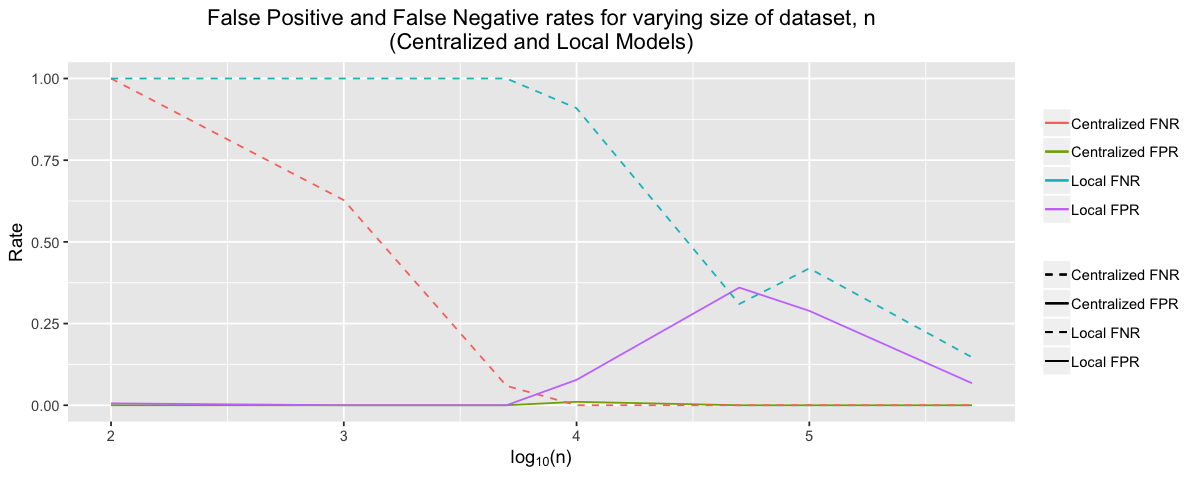

In [30]:
library(ggplot2)
# plot FPRs and FNRs for both mechanisms
x_vals <- log10(agg_final_results$n);
p1 <- ggplot(agg_final_results) + 
    geom_line(aes(x=x_vals, y=agg_final_results$central_FPR, color = "Centralized FPR", linetype="Centralized FPR")) +
    geom_line(aes(x=x_vals, y=agg_final_results$central_FNR, color = "Centralized FNR", linetype = "Centralized FNR")) +
    geom_line(aes(x=x_vals, y=agg_final_results$local_FPR, color = "Local FPR", linetype = "Local FPR")) +
    geom_line(aes(x=x_vals, y=agg_final_results$local_FNR, color = "Local FNR", linetype = "Local FNR"));
p1 <- p1 + scale_linetype_manual(values = c("Centralized FPR"="solid", "Centralized FNR"="dashed", 
                                            "Local FPR" = "solid", "Local FNR"="dashed"));
p1 <- p1 + labs(x = expression("log"[10]*"(n)"), y = 'Rate', title = 
        'False Positive and False Negative rates for varying size of dataset, n\n(Centralized and Local Models)') + 
    theme(plot.title = element_text(hjust = 0.5), legend.title = element_blank());

options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p1 #show plot

For the centralized DP version of the SQ algorithm, we see that the false-positive rate for the predictions essentially stays at zero as $n$ increases and the false-negative rate decreases from 1.0 at $n=100$ to 0 at $n=10,000$. This is what I would expect because with smaller datasets, it is more difficult to find predictors that when in a conjunction accurately predict the **targetted** value because the global sensitivity ($\frac{1}{n}$) is higher, so the scale for the Laplace noise that is added is greater. So when $n$ is small, the false-positive rate will be low because it is difficult to find predictors that when in conjunction will give **targetted=1**. As a result, all of the true **targetted=1** points are predicted as **targetted=0**, producing a high false-negative rate. As $n$ increases, the false-negative rate decreases because the centralized model is able to output predictors that when in conjunction do predict the true **targetted=1** points correctly.

For the local DP version of the SQ algorithm, we see that false-positive rate stays close to 0 until $n=5000$, where it begins to increase until $n=50,000$, after which it decreases close to 0 at $n=500,000$. This can be rationalized because again with smaller datasets (small $n$) it is difficult to find predictors that when in a conjunction accurately predict the **targetted** value because of the noise introduced by the randomized responses. So with small $n$, we predict everything to be **targetted=0**. As $n$ increases, the false-positive rate picks up while the false-negative rate drops, which is expected because we are finding some subset of predictors that in conjunction accurately predict the true **targetted=1** points but also incorrectly predict some true **targetted=0** points as 1s. As $n$ gets large ($n>100,000$), the subset of predictors $\hat S$ better reflects the true subset $S$ with less false-positive predictors because the noise from the randomized responses is averaged out by the large $n$. Therefore, we see both the false-positive and false-negative rates go to zero as $n$ increases.